<a href="https://colab.research.google.com/github/viniciusrpb/cloud_image_classification/blob/main/invoices_lstm_bert_sapato_camisa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
#!cp -r "/content/drive/My Drive/nfce/base_nfce_unbr.dsv" "nfce.dsv"

In [3]:
#!pip install -U keras
#!pip install -U tensorflow
#!pip install transformers
#!pip install tensorflow_text
#!pip install -q -U "tensorflow-text==2.8.*"

Importando as classes necessárias a partir das bibliotecas

In [4]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from keras.models import Model,Sequential
from keras.layers import Dense,Activation,Input,LSTM,Bidirectional,Dropout,SpatialDropout1D
from tensorflow.keras.optimizers import SGD,Adam
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
import transformers
print(transformers.__version__)
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from keras.layers.embeddings import Embedding

4.18.0


### Carregamento do corpus para Pandas DataFrames



**PS.:** Mais informações sobre a divisão de um conjunto de dados em treinamento, validação e teste, você encontra nesse [link](https://machinelearningmastery.com/difference-test-validation-datasets/).


In [5]:
path = 'nfce.dsv'

In [6]:
raw_df = pd.read_csv(path,encoding='latin_1',engine='python',error_bad_lines=False,sep='|')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
Skipping line 299273: field larger than field limit (131072)
Skipping line 1009995: '|' expected after '"'
Skipping line 1023200: '|' expected after '"'
Skipping line 1026998: '|' expected after '"'
Skipping line 1121213: '|' expected after '"'
Skipping line 1143346: field larger than field limit (131072)
Skipping line 1650210: field larger than field limit (131072)
Skipping line 2219225: '|' expected after '"'
Skipping line 2219233: '|' expected after '"'
Skipping line 2332476: field larger than field limit (131072)
Skipping line 2593362: field larger than field limit (131072)
Skipping line 3079129: '|' expected after '"'
Skipping line 3100827: field larger than field limit (131072)
Skipping line 3565499: '|' expected after '"'
Skipping line 3577382: u

In [7]:
raw_df

,DESC_1W,FREQ_1W,DESC_2W,FREQ_2W,FQREL_2W,NCM,FREQ_NCM,FQREL_NCM,CST,FREQ_CST,FQREL_CST
0,gasolina,81152945,comum,43004215,"0,529915643",27101259,41268879,"0,959647304",60,41268879.0,1
1,gasolina,81152945,comum,43004215,"0,529915643",84133010,1706357,"0,039678831",60,1706357.0,1
2,gasolina,81152945,comum,43004215,"0,529915643",27101921,28449,"0,00066154",60,28449.0,1
3,gasolina,81152945,comum,43004215,"0,529915643",27101932,530,"0,000012324",60,530.0,1
4,gasolina,81152945,c,25854690,"0,318592135",27101259,24589443,"0,951063153",60,24589443.0,1
...,...,...,...,...,...,...,...,...,...,...,...
3577340,brinq.bingo,1,globo,1,1,95030099,1,1,60,1.0,1
3577341,sepde,1,dedos,1,1,39269090,1,1,60,1.0,1
3577342,##64029990#1001245430320331,1,rcs,1,1,64029990,1,1,0,1.0,1
3577343,01204247,1,shortdoll,1,1,61083200,1,1,0,1.0,1


Informações sobre cada parte do *corpus* de tweets:

In [8]:
flag_tenis = raw_df['DESC_1W'] == "tenis" 
flag_sap = raw_df['DESC_1W'] == "sapato"
#flag_camis = raw_df['DESC_1W'] == "camisa"
#flag_camiseta = raw_df['DESC_1W'] == "camiseta"

df = raw_df[flag_tenis | flag_sap ]#| flag_camis | flag_camiseta]# or flag_et or flag_die]

### Pré-processamento dos Tweets

Remove o atributo **id**, pois não será necessário o uso desse atributo no processo de classificação.



In [9]:
proc_df = pd.DataFrame()
proc_df['DESC'] = df['DESC_1W']+" "+df['DESC_2W']+" "+df['NCM'].astype(str)
proc_df['CST'] = df['CST']

Além disso, por questões do uso dos métodos da classe Sequential no Keras-Tensorflow, convertemos o atributo de classe para o tipo categórico e para cada instância, mapeamos seus valores para números inteiros. Lembre-se que os **modelos de aprendizado de máquina processam apenas números inteiros ou reais**.

In [10]:
proc_df

,DESC,CST
517770,tenis nike 64041100,0
517771,tenis nike 64041100,60
517772,tenis nike 64039990,0
517773,tenis nike 64039990,60
517774,tenis nike 64029990,0
...,...,...
1028668,sapato slip 64042000,0
1028669,sapato gozul 64035990,0
1028670,sapato 17.155/17 64029990,0
1028671,sapato 710593 64039990,0


In [11]:
proc_df['CST'] = pd.Categorical(proc_df['CST'])

proc_df['CST'] = proc_df['CST'].cat.codes

Vamos ver como e repare que o mapeamento do atributo categórico "polarity" para valores categóricos inteiros ficou como:

*   polaridade "negativa" *(negative)*: valor $0$
*   polaridade "neutra" *(neutral)*: valor $1$
*   polaridade "positiva" *(positive)*: valor $2$

In [12]:
# split train dataset into train, validation and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(proc_df['DESC'], proc_df['CST'], 
                                                                    test_size=0.3, 
                                                                    stratify= proc_df['CST'])


val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

In [13]:
train_labels

1028514    0
518344     0
518170     0
521399     0
1027143    0
          ..
517846     4
519029     0
520050     0
519615     0
1027280    0
Name: CST, Length: 3841, dtype: int8

In [14]:
from keras.utils.np_utils import to_categorical

num_classes = 5

y_train_enc = to_categorical(list(train_labels),num_classes)
y_valid_enc = to_categorical(list(val_labels),num_classes)
y_test_enc = to_categorical(list(test_labels),num_classes)

A seguir, transformamos os valores da classe "polaridade", nossa classe de interesse, para one-hot-encoding. Nessa representação, como temos três classes, utilizaremos três bits, em que para cada instância, apenas um deles estará ativado (com valor $1$) com base na presença do valor classe.

Veja como fica a representação one-hot encoding para cada classe:

*   polaridade "negativa" *(negative)*: valor $0$, one hot encoding: $[1,0,0]$
*   polaridade "neutra" *(neutral)*: valor $1$, one hot encoding: $[0,1,0]$
*   polaridade "positiva" *(positive)*: valor $2$, one hot encoding: $[0,0,1]$

Utilizaremos a função *to_categorical* do Keras para esse propósito (se bem que poderíamos facilmente implementar uma por nossa conta):

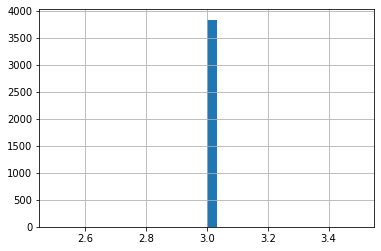

In [15]:
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

Apenas verificando como ficou o pré-processamento do atributo de classe:

### Extração de características dos tweets

 Bidirectional Encoder Representations from Transformers (BERT). The BERT architecture is composed of several Transformer encoders stacked together. Further, each Transformer encoder is composed of two sub-layers: a feed-forward layer and a self-attention layer.

 Primeiramente, fazemos os downloads do modelo BERT de referência:


In [16]:
bert_model_name = 'universal-sentence-encoder-multilingual/3'
tfhub_handle_encoder = 'https://tfhub.dev/jeongukjae/distilbert_multi_cased_L-6_H-768_A-12/1'
tfhub_handle_preprocess = 'https://tfhub.dev/jeongukjae/distilbert_en_uncased_preprocess/2'

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/jeongukjae/distilbert_multi_cased_L-6_H-768_A-12/1
Preprocess model auto-selected: https://tfhub.dev/jeongukjae/distilbert_en_uncased_preprocess/2


In [17]:
bert_preprocess = hub.KerasLayer(tfhub_handle_preprocess)
bert_encoder = hub.KerasLayer(tfhub_handle_encoder)

In [18]:
train_text=list(train_text)

Colocamos as instâncias (juntamente com seus vetores BERT) nas respectivas matrizes $X$ (para cada tipo de dados), em que cada linha de $X$ está associada a um *tweet*. Repare que as classes (labels, rótulos etc) já foram separadas anteriormente e estão armazenadas nas variáveis ```y```. Por exemplo, a instância de treinamento $\mathbf{x_i}$, denotada por ```X_train[i]``` é da classe ```y_train[i]``` $\in \{0,1,2\}$.

In [20]:
sample = [train_text[0]]
text_preprocessed = bert_preprocess(sample)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')

bert_model = hub.KerasLayer(tfhub_handle_encoder)

bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Keys       : ['input_word_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [  101 20066 10610  3622 26250 19714 20958  8889  2692   102     0     0]
Input Mask : [1 1 1 1 1 1 1 1 1 1 0 0]
Loaded BERT: https://tfhub.dev/jeongukjae/distilbert_multi_cased_L-6_H-768_A-12/1
Pooled Outputs Shape:(1, 768)
Pooled Outputs Values:[ 0.37743148 -0.19609459  0.42409688  0.15457141  0.45795184  0.02528752
 -0.16073605  0.00144558  0.03351593  0.29523426  0.04428848 -0.01796117]
Sequence Outputs Shape:(1, 128, 768)
Sequence Outputs Values:[[ 0.37743148 -0.19609459  0.42409688 ...  0.11274129 -0.107058
  -0.04510769]
 [ 0.1443631  -0.29875037  0.47425768 ...  0.70384    -0.2616426
  -0.29228422]
 [ 0.1986513  -0.6661308   0.16347966 ...  0.3671059   0.20244199
  -0.28319168]
 ...
 [ 0.40633783 -0.28701204  0.63489866 ...  0.29604745 -0.09438366
  -0.07882378]
 [ 0.6099305  -0.1312302   0.6780729  ...  0.38354868  0.37528563
  -0.16295418]
 [ 0.45841905 -0.25336426  0.47911844 ...  0.51271945  0.

In [21]:
vocab_size = 128
num_classes=5

### Modelo de Classificação: BERT Input + LSTM + Sigmoid Function





In [22]:
num_neurons = 64
num_embeddings = 128

In [36]:
text_input = Input(shape=(), dtype=tf.string, name='text')
preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
encoder_inputs = preprocessing_layer(text_input)
encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
outputs = encoder(encoder_inputs)
net = outputs['pooled_output']
model = Model(text_input, net)

In [37]:
inputs = model.inputs[:2]
bert_out = model.output
newReshape = tf.keras.layers.Reshape((768,1), name='newReshape')(bert_out)
#bert_out.shape

In [38]:
lstm = LSTM(256)(newReshape)
newout = Dense(768,activation='relu')(lstm)
preds = Dense(num_classes, activation='sigmoid')(newout)
model = Model(inputs, preds)

In [39]:
val_text = np.array(list(val_text))
train_text = np.array(list(train_text))

O ajuste do modelo para o treinamento consiste em utilizarmos um otimizador da classe SGD (*Stochastic Gradient Descent*), em que colocamos aleatoriamente um valor da taxa de aprendizado ```learning_rate=0.001```.

Outra alteração se trata da função *loss* (que calcula o erro da modelo). Como temos um problema de classificação multiclasse, temos que empregar a função ```categorical_crossentropy```.

In [40]:
#sgd = SGD(learning_rate=3e-5)

adam = Adam(learning_rate=0.00001,decay = 1e-6)

model.compile(loss="categorical_crossentropy",optimizer=adam,metrics=['accuracy'])
history_fine = model.fit(train_text, y_train_enc,validation_data=(val_text,y_valid_enc),epochs=3)

Epoch 1/3
121/121 [==============================] - 77s 565ms/step - loss: 0.9951 - accuracy: 0.9305 - val_loss: 0.4846 - val_accuracy: 0.9332
Epoch 2/3
121/121 [==============================] - 67s 553ms/step - loss: 0.3482 - accuracy: 0.9453 - val_loss: 0.1956 - val_accuracy: 0.9769
Epoch 3/3
121/121 [==============================] - 67s 554ms/step - loss: 0.1469 - accuracy: 0.9779 - val_loss: 0.1111 - val_accuracy: 0.9806


Vamos analisar o comportamento da função *loss* no decorrer das épocas:

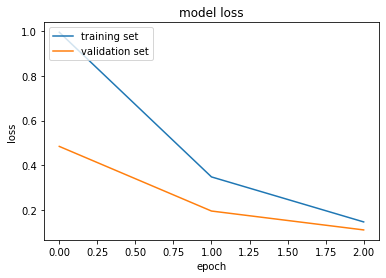

In [41]:
loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']


plt.plot(history_fine.history['loss'])
plt.plot(history_fine.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.show()

In [43]:
test_text = np.array(list(test_text))
y_prob = model.predict(test_text)
y_pred = np.argmax(y_prob,axis=1)

Vamos imprimir os resultados da classificação de *tweets* para os dados de teste:

In [44]:
print(classification_report(list(test_labels),y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       768
           1       0.91      1.00      0.95        41
           2       0.00      0.00      0.00         7
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         7

    accuracy                           0.98       824
   macro avg       0.38      0.40      0.39       824
weighted avg       0.96      0.98      0.97       824



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Outra possibilidade é o uso do método *evaluate*:



In [ ]:
print(model.evaluate(X_test,y_test_enc))